In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

from clean import clean_games

Let's clean & load our data. For time's sake, we're only going to use years 1990-2020.

In [2]:
game_df = clean_games("data/games_scraped.pickle", start_year=1990)

In [3]:
game_df.shape

(6559, 155)

In [4]:
pd.set_option("display.max_columns", 250)
pd.set_option("display.max_rows", 73)

In [5]:
# print all columns
for col_name in game_df.columns:
    print(col_name)

team
year
team_year
date
opp
week_num
log_year
game_day_of_week
game_outcome
team_record
pts_off
margin
pts_def
first_down_off
yards_off
pass_yds_off
rush_yds_off
to_off
first_down_def
yards_def
pass_yds_def
rush_yds_def
to_def
game_time
overtime
team_home_game
to2_off
to2_def
game_id
result_tie
result_win
wins
losses
ties
season_week
playoff_game
prev_season_week
prev_wins
prev_losses
prev_ties
prev_pts_off
prev_pts_def
prev_margin
prev_first_down_off
prev_yards_off
prev_pass_yds_off
prev_rush_yds_off
prev_to_off
prev_to2_off
prev_first_down_def
prev_yards_def
prev_pass_yds_def
prev_rush_yds_def
roll16_num_ties
roll16_num_wins
roll3_num_ties
roll3_num_wins
prev_to_def
prev_to2_def
prev_result_tie
prev_result_win
off_bye
roll3_result_win
roll3_result_tie
roll3_pts_off
roll3_pts_def
roll3_margin
roll3_first_down_off
roll3_yards_off
roll3_pass_yds_off
roll3_rush_yds_off
roll3_to_off
roll3_to2_off
roll3_yards_def
roll3_pass_yds_def
roll3_rush_yds_def
roll3_to_def
roll3_to2_def
ewma_result

In [6]:
# construct a list containing all of the columns we could use in model
indicators = ['prev_', 'roll3', 'ewma_']
key_variables = [col for col in game_df.columns if col[:5] in indicators]
key_variables.sort()

additional = ['year', 'date', 'team', 'team_home_game', 'opp', 'margin']

for col in additional[::-1]:
    key_variables.insert(0, col)

key_variables

['year',
 'date',
 'team',
 'team_home_game',
 'opp',
 'margin',
 'ewma_first_down_off',
 'ewma_first_down_off_opp',
 'ewma_margin',
 'ewma_margin_diff',
 'ewma_margin_opp',
 'ewma_pass_yds_def',
 'ewma_pass_yds_def_opp',
 'ewma_pass_yds_off',
 'ewma_pass_yds_off_opp',
 'ewma_pts_def',
 'ewma_pts_def_opp',
 'ewma_pts_off',
 'ewma_pts_off_opp',
 'ewma_result_tie',
 'ewma_result_win',
 'ewma_result_win_opp',
 'ewma_result_win_opp',
 'ewma_rush_yds_def',
 'ewma_rush_yds_def_opp',
 'ewma_rush_yds_off',
 'ewma_rush_yds_off_opp',
 'ewma_to2_def',
 'ewma_to2_def_opp',
 'ewma_to2_off',
 'ewma_to2_off_opp',
 'ewma_to_def',
 'ewma_to_def_opp',
 'ewma_to_off',
 'ewma_to_off_opp',
 'ewma_yards_def',
 'ewma_yards_def_opp',
 'ewma_yards_off',
 'ewma_yards_off_opp',
 'prev_first_down_def',
 'prev_first_down_def_opp',
 'prev_first_down_off',
 'prev_first_down_off_opp',
 'prev_losses',
 'prev_losses_opp',
 'prev_margin',
 'prev_margin_opp',
 'prev_pass_yds_def',
 'prev_pass_yds_def_opp',
 'prev_pass_yd

Our DF is still too large to use `df.info()`.

Let's split the columns into sections. Since we have so many columns, we need to do quite a bit of splitting.

Let's start with a small selection of columns.

In [7]:
small_df = game_df[['margin', 'team', 'opp', 'game_id', 'year', 'roll3_margin',
                    'ewma_margin', 'roll3_to_off', 'roll3_to2_off', 'ewma_to_def', 'ewma_to2_def']]

In [8]:
indicators = ['prev_', 'roll3', 'ewma_']

prev_vars = [col for col in game_df.columns if col[:5] == 'prev_']
roll3_vars = [col for col in game_df.columns if col[:5] == 'roll3']
ewma_vars = [col for col in game_df.columns if col[:5] == 'ewma_']

# remove dupe in ewma_vars
ewma_vars = list(dict.fromkeys(ewma_vars))

for grp in [prev_vars, roll3_vars, ewma_vars]:
    for col in additional[::-1]:
        grp.insert(0, col)

prev_df = game_df[prev_vars]
roll3_df = game_df[roll3_vars]
ewma_df = game_df[roll3_vars]

In [9]:
# sns.pairplot(small_df, plot_kws=dict(alpha=.1, edgecolor='none'))

In [10]:
game_df['def_summ_test1'] = \
    ((game_df['ewma_yards_def'].to_numpy() / (game_df['ewma_to_def'].to_numpy() + 1)
      .astype(float)))

game_df['def_summ_test2'] = \
    ((game_df['ewma_yards_def'].to_numpy() / (game_df['ewma_to2_def'].to_numpy() + 1)
     .astype(float)))

def_df = game_df[['year', 'team', 'opp', 'margin', 'ewma_result_win', 'ewma_yards_def',
                  'ewma_to_def', 'ewma_to2_def', 'def_summ_test1', 'def_summ_test2']]
def_df.head(5)


,year,team,opp,margin,ewma_result_win,ewma_yards_def,ewma_to_def,ewma_to2_def,def_summ_test1,def_summ_test2
0,1990,crd,was,-28.0,0.332,321.577,1.371,3.360,135.629270,73.756193
1,1990,crd,dal,17.0,0.233,355.755,0.961,2.357,181.415094,105.974084
2,1990,crd,nyg,-1.0,0.427,291.072,1.477,4.037,117.509891,57.786778
3,1990,crd,chi,-10.0,0.332,297.740,1.593,4.029,114.824528,59.204613
4,1990,crd,mia,-20.0,0.265,314.725,1.474,3.418,127.213015,71.236985


In [11]:
# sns.pairplot(def_df, plot_kws=dict(alpha=.1, edgecolor='none'))

In [12]:
# new ewma cols? i.e. ewma_total_yards_off - ewma_total_yards_off_opp

# create list of all ewma vars + row indicators & remove dupes
ewma_vars
ewma_vars

['year',
 'date',
 'team',
 'team_home_game',
 'opp',
 'margin',
 'ewma_result_win',
 'ewma_result_tie',
 'ewma_pts_off',
 'ewma_pts_def',
 'ewma_margin',
 'ewma_first_down_off',
 'ewma_yards_off',
 'ewma_pass_yds_off',
 'ewma_rush_yds_off',
 'ewma_to_off',
 'ewma_to2_off',
 'ewma_yards_def',
 'ewma_pass_yds_def',
 'ewma_rush_yds_def',
 'ewma_to_def',
 'ewma_to2_def',
 'ewma_result_win_opp',
 'ewma_pts_off_opp',
 'ewma_pts_def_opp',
 'ewma_margin_opp',
 'ewma_first_down_off_opp',
 'ewma_yards_off_opp',
 'ewma_pass_yds_off_opp',
 'ewma_rush_yds_off_opp',
 'ewma_to_off_opp',
 'ewma_to2_off_opp',
 'ewma_yards_def_opp',
 'ewma_pass_yds_def_opp',
 'ewma_rush_yds_def_opp',
 'ewma_to_def_opp',
 'ewma_to2_def_opp',
 'ewma_margin_diff']

In [13]:
opp_ewmas = [var for var in ewma_vars if var[-4:] == '_opp']
team_ewmas = [var for var in ewma_vars[6:] if var not in opp_ewmas]

opp_ewmas.sort()
team_ewmas.sort()

In [14]:
opp_ewmas, team_ewmas

(['ewma_first_down_off_opp',
  'ewma_margin_opp',
  'ewma_pass_yds_def_opp',
  'ewma_pass_yds_off_opp',
  'ewma_pts_def_opp',
  'ewma_pts_off_opp',
  'ewma_result_win_opp',
  'ewma_rush_yds_def_opp',
  'ewma_rush_yds_off_opp',
  'ewma_to2_def_opp',
  'ewma_to2_off_opp',
  'ewma_to_def_opp',
  'ewma_to_off_opp',
  'ewma_yards_def_opp',
  'ewma_yards_off_opp'],
 ['ewma_first_down_off',
  'ewma_margin',
  'ewma_margin_diff',
  'ewma_pass_yds_def',
  'ewma_pass_yds_off',
  'ewma_pts_def',
  'ewma_pts_off',
  'ewma_result_tie',
  'ewma_result_win',
  'ewma_rush_yds_def',
  'ewma_rush_yds_off',
  'ewma_to2_def',
  'ewma_to2_off',
  'ewma_to_def',
  'ewma_to_off',
  'ewma_yards_def',
  'ewma_yards_off'])

In [15]:
plot_cols = game_df.loc[:, ['ewma_margin', 'ewma_margin_opp', 'ewma_pts_off',
                'ewma_pts_def', 'ewma_pts_off_opp', 'ewma_pts_def_opp',
                'ewma_to2_off', 'ewma_to2_def', 'ewma_to2_off_opp', 'ewma_to2_def_opp',
                   'margin']]



In [16]:
# sns.pairplot(plot_cols, plot_kws=dict(alpha=.1, edgecolor='none'))

In [17]:
plot_cols.describe()

,ewma_margin,ewma_margin_opp,ewma_pts_off,ewma_pts_def,ewma_pts_off_opp,ewma_pts_def_opp,ewma_to2_off,ewma_to2_def,ewma_to2_off_opp,ewma_to2_def_opp,margin
count,6559.000000,6559.000000,6559.000000,6559.000000,6559.000000,6559.000000,6559.000000,6559.000000,6559.000000,6559.000000,6559.000000
mean,0.172642,0.513378,21.609958,21.437301,21.718997,21.205618,4.757419,4.875785,4.779680,4.876338,-0.527824
std,7.389596,7.478395,5.277361,4.734322,5.284417,4.796117,2.756536,2.879775,2.958181,2.790398,14.807161
min,-37.991000,-32.195000,2.048000,4.038000,4.038000,5.165000,0.000000,0.000000,0.000000,0.000000,-58.000000
25%,-4.909000,-4.516500,17.974500,18.222500,18.062500,17.833500,2.809000,2.850000,2.651000,2.867500,-10.000000
50%,0.347000,0.578000,21.387000,21.256000,21.532000,21.046000,4.274000,4.336000,4.247000,4.415000,-1.000000
75%,5.389500,5.611000,24.985000,24.588500,25.085000,24.431500,6.217500,6.270500,6.237500,6.343500,8.000000
max,29.718000,29.049000,46.423000,43.172000,44.873000,38.619000,30.369000,27.778000,43.304000,30.528000,59.000000


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

def split_and_validate(X, y):
    '''
        For a set of features and target X, y, perform a 80/20 train/val split, 
        fit and validate a linear regression model, and report results
    '''

    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    print(y_train[:5])
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 
    
    return lr_model

In [19]:
game_df.columns

Index(['team', 'year', 'team_year', 'date', 'opp', 'week_num', 'log_year',
       'game_day_of_week', 'game_outcome', 'team_record',
       ...
       'ewma_to_off_opp', 'ewma_to2_off_opp', 'ewma_yards_def_opp',
       'ewma_pass_yds_def_opp', 'ewma_rush_yds_def_opp', 'ewma_to_def_opp',
       'ewma_to2_def_opp', 'ewma_margin_diff', 'def_summ_test1',
       'def_summ_test2'],
      dtype='object', length=157)

In [20]:
mask = game_df['team_year'] == 'chi-2019'
game_df[mask][['ewma_pts_off', 'ewma_pts_def']]

,ewma_pts_off,ewma_pts_def
2345,17.834,13.205
2346,17.286,11.053
2347,18.225,14.328
2348,19.734,19.156
2349,18.982,18.721
2350,18.055,19.331
2351,18.394,18.229
2352,16.516,18.026
2353,16.907,17.393
2354,17.981,17.787


Let's try all of the roll3 columns and compare the results to ewma columns. 

In [21]:
ewma_cols = [col for col in game_df.columns if col[:4] == 'ewma']
roll3_cols = [col for col in game_df.columns if col[:4] == 'roll']

In [22]:
ewma_cols = list(set(ewma_cols))

In [23]:
X = game_df[ewma_cols]
y = game_df['result_win']

split_and_validate(X, y)

4978     1
6675     0
3324     0
10541    1
107      0
Name: result_win, dtype: uint8

Validation R^2 score was: 0.05446593353495588
Feature coefficient results: 

ewma_to_def : -0.08
ewma_pass_yds_off : 3.15
ewma_rush_yds_def : 32.90
ewma_margin : 9.46
ewma_first_down_off : 0.01
ewma_to2_off : 0.01
ewma_first_down_off_opp : -0.01
ewma_pass_yds_def_opp : -10.03
ewma_to_off_opp : 0.06
ewma_pts_off : -12.85
ewma_margin_opp : 6.05
ewma_to2_def_opp : -0.00
ewma_pts_def : 12.85
ewma_yards_def : -32.90
ewma_pts_def_opp : 2.64
ewma_pass_yds_off_opp : -3.14
ewma_to_def_opp : 0.03
ewma_margin_diff : 3.41
ewma_to2_def : 0.00
ewma_rush_yds_off_opp : -3.14
ewma_rush_yds_off : 3.15
ewma_result_win_opp : -0.07
ewma_result_win_opp : -0.07
ewma_yards_off : -3.15
ewma_result_tie : -0.22
ewma_pts_off_opp : -2.65
ewma_rush_yds_def_opp : -10.02
ewma_yards_def_opp : 10.03
ewma_result_win : 0.08
ewma_to_off : -0.04
ewma_to2_off_opp : -0.01
ewma_pass_yds_def : 32.90
ewma_yards_off_opp : 3.14


LinearRegression()

In [24]:
X = game_df[roll3_cols]
y = game_df['result_win']

split_and_validate(X, y)

4978     1
6675     0
3324     0
10541    1
107      0
Name: result_win, dtype: uint8

Validation R^2 score was: 0.06129356568040778
Feature coefficient results: 

roll16_num_ties : -0.04
roll16_num_wins : 0.04
roll3_num_ties : 0.01
roll3_num_wins : -5.43
roll3_result_win : 16.20
roll3_result_tie : 0.00
roll3_pts_off : 15.84
roll3_pts_def : -15.84
roll3_margin : -15.84
roll3_first_down_off : 0.00
roll3_yards_off : -42.01
roll3_pass_yds_off : 42.01
roll3_rush_yds_off : 42.01
roll3_to_off : -0.03
roll3_to2_off : 0.00
roll3_yards_def : -10.51
roll3_pass_yds_def : 10.51
roll3_rush_yds_def : 10.51
roll3_to_def : -0.04
roll3_to2_def : 0.00
roll16_num_wins_opp : -0.04
roll16_num_ties_opp : -0.06
roll3_num_wins_opp : 0.25
roll3_num_ties_opp : -0.00
roll3_result_win_opp : -0.71
roll3_result_tie_opp : -0.00
roll3_result_tie_opp : -0.00
roll3_result_tie_opp : -0.00
roll3_result_tie_opp : -0.00
roll3_pts_off_opp : -2.22
roll3_pts_def_opp : 2.22
roll3_margin_opp : 2.21
roll3_first_down_off_opp : -0

LinearRegression()

At first glance, it appears ewma is better. Let's break them into halves to confirm.

In [25]:
split = len(ewma_cols) // 2

X = game_df[ewma_cols[:split]]
y = game_df['result_win']

split_and_validate(X, y)

4978     1
6675     0
3324     0
10541    1
107      0
Name: result_win, dtype: uint8

Validation R^2 score was: 0.058101564562311525
Feature coefficient results: 

ewma_to_def : -0.06
ewma_pass_yds_off : -0.00
ewma_rush_yds_def : -0.00
ewma_margin : 13.71
ewma_first_down_off : 0.01
ewma_to2_off : 0.00
ewma_first_down_off_opp : -0.01
ewma_pass_yds_def_opp : -0.00
ewma_to_off_opp : 0.01
ewma_pts_off : -13.69
ewma_margin_opp : -0.01
ewma_to2_def_opp : 0.00
ewma_pts_def : 13.69
ewma_yards_def : 0.00
ewma_pts_def_opp : -0.00
ewma_pass_yds_off_opp : -0.00


LinearRegression()

In [26]:
split = len(roll3_cols) // 2

X = game_df[roll3_cols[:split]]
y = game_df['result_win']

split_and_validate(X, y)

4978     1
6675     0
3324     0
10541    1
107      0
Name: result_win, dtype: uint8

Validation R^2 score was: 0.013838079027741701
Feature coefficient results: 

roll16_num_ties : -0.11
roll16_num_wins : 0.01
roll3_num_ties : 0.04
roll3_num_wins : -7.50
roll3_result_win : 22.52
roll3_result_tie : 0.01
roll3_pts_off : 23.37
roll3_pts_def : -23.37
roll3_margin : -23.36
roll3_first_down_off : 0.00
roll3_yards_off : -38.66
roll3_pass_yds_off : 38.66
roll3_rush_yds_off : 38.66
roll3_to_off : -0.02
roll3_to2_off : 0.00
roll3_yards_def : -14.60
roll3_pass_yds_def : 14.60
roll3_rush_yds_def : 14.60
roll3_to_def : -0.04
roll3_to2_def : 0.00


LinearRegression()

And now the other half...

In [27]:
split = len(ewma_cols) // 2

X = game_df[ewma_cols[split:]]
y = game_df['result_win']

split_and_validate(X, y)

4978     1
6675     0
3324     0
10541    1
107      0
Name: result_win, dtype: uint8

Validation R^2 score was: 0.0638973681459607
Feature coefficient results: 

ewma_to_def_opp : 0.02
ewma_margin_diff : 0.01
ewma_to2_def : -0.01
ewma_rush_yds_off_opp : 0.00
ewma_rush_yds_off : 0.00
ewma_result_win_opp : -0.05
ewma_result_win_opp : -0.05
ewma_yards_off : -0.00
ewma_result_tie : -0.20
ewma_pts_off_opp : -0.00
ewma_rush_yds_def_opp : 0.00
ewma_yards_def_opp : 0.00
ewma_result_win : 0.11
ewma_to_off : -0.01
ewma_to2_off_opp : -0.00
ewma_pass_yds_def : -0.00
ewma_yards_off_opp : -0.00


LinearRegression()

In [28]:
split = len(roll3_cols) // 2

X = game_df[roll3_cols[split:]]
y = game_df['result_win']

split_and_validate(X, y)

4978     1
6675     0
3324     0
10541    1
107      0
Name: result_win, dtype: uint8

Validation R^2 score was: 0.03369825452755526
Feature coefficient results: 

roll16_num_wins_opp : -0.01
roll16_num_ties_opp : -0.01
roll3_num_wins_opp : 4.38
roll3_num_ties_opp : -0.02
roll3_result_win_opp : -13.18
roll3_result_tie_opp : -0.01
roll3_result_tie_opp : -0.01
roll3_result_tie_opp : -0.01
roll3_result_tie_opp : -0.01
roll3_pts_off_opp : -4.02
roll3_pts_def_opp : 4.02
roll3_margin_opp : 4.02
roll3_first_down_off_opp : -0.00
roll3_yards_off_opp : 6.37
roll3_pass_yds_off_opp : -6.37
roll3_rush_yds_off_opp : -6.37
roll3_to_off_opp : 0.02
roll3_to2_off_opp : -0.00
roll3_yards_def_opp : -23.27
roll3_pass_yds_def_opp : 23.27
roll3_rush_yds_def_opp : 23.27
roll3_to_def_opp : 0.01
roll3_to2_def_opp : 0.00


LinearRegression()

Okay, that checks out. Moving forward, we'll use columns with the `ewma` prefix.

Let's also start factoring in home game, which we know often impacts who wins a game.

Here, we'll introduce `off_bye`, which tells us whether or not the team is coming off a bye week. Perhaps teams play better when they've had an extra week of rest time.

In [29]:
X = game_df[[
 'off_bye',
 'off_bye_opp',
 'team_home_game',
 'ewma_result_win',
 'ewma_result_tie',
 'ewma_pts_off',
 'ewma_pts_def',
 'ewma_margin',
 'ewma_first_down_off',
 'ewma_yards_off',
 'ewma_pass_yds_off',
 'ewma_rush_yds_off',
 'ewma_to_off',
 'ewma_to2_off',
 'ewma_yards_def',
 'ewma_pass_yds_def',
 'ewma_rush_yds_def',
 'ewma_to_def',
 'ewma_to2_def',
 'ewma_result_win_opp',
 'ewma_pts_off_opp',
 'ewma_pts_def_opp',
 'ewma_margin_opp',
 'ewma_first_down_off_opp',
 'ewma_yards_off_opp',
 'ewma_pass_yds_off_opp',
 'ewma_rush_yds_off_opp',
 'ewma_to_off_opp',
 'ewma_to2_off_opp',
 'ewma_yards_def_opp',
 'ewma_pass_yds_def_opp',
 'ewma_rush_yds_def_opp',
 'ewma_to_def_opp',
 'ewma_to2_def_opp']]

y = game_df['result_win']

split_and_validate(X, y)

4978     1
6675     0
3324     0
10541    1
107      0
Name: result_win, dtype: uint8

Validation R^2 score was: 0.08334276153766951
Feature coefficient results: 

off_bye : 0.00
off_bye_opp : 0.00
team_home_game : 0.17
ewma_result_win : 0.07
ewma_result_tie : -0.13
ewma_pts_off : -10.82
ewma_pts_def : 10.82
ewma_margin : 10.83
ewma_first_down_off : 0.01
ewma_yards_off : -4.51
ewma_pass_yds_off : 4.51
ewma_rush_yds_off : 4.51
ewma_to_off : -0.04
ewma_to2_off : 0.01
ewma_yards_def : -28.76
ewma_pass_yds_def : 28.76
ewma_rush_yds_def : 28.76
ewma_to_def : -0.08
ewma_to2_def : 0.00
ewma_result_win_opp : -0.08
ewma_result_win_opp : -0.08
ewma_pts_off_opp : 0.77
ewma_pts_def_opp : -0.78
ewma_margin_opp : -0.79
ewma_first_down_off_opp : -0.01
ewma_yards_off_opp : 3.74
ewma_pass_yds_off_opp : -3.74
ewma_rush_yds_off_opp : -3.74
ewma_to_off_opp : 0.05
ewma_to2_off_opp : -0.01
ewma_yards_def_opp : 9.03
ewma_pass_yds_def_opp : -9.03
ewma_rush_yds_def_opp : -9.03
ewma_to_def_opp : 0.03
ewma_to2_d

LinearRegression()

In [30]:
X = game_df[[
 'log_year',
 'team_home_game',
 'ewma_result_win',
 'ewma_result_tie',
 'ewma_pts_off',
 'ewma_pts_def',
 'ewma_margin',
 'ewma_first_down_off',
 'ewma_yards_off',
 'ewma_pass_yds_off',
 'ewma_rush_yds_off',
 'ewma_to_off',
 'ewma_to2_off',
 'ewma_yards_def',
 'ewma_pass_yds_def',
 'ewma_rush_yds_def',
 'ewma_to_def',
 'ewma_to2_def',
 'ewma_result_win_opp',
 'ewma_pts_off_opp',
 'ewma_pts_def_opp',
 'ewma_margin_opp',
 'ewma_first_down_off_opp',
 'ewma_yards_off_opp',
 'ewma_pass_yds_off_opp',
 'ewma_rush_yds_off_opp',
 'ewma_to_off_opp',
 'ewma_to2_off_opp',
 'ewma_yards_def_opp',
 'ewma_pass_yds_def_opp',
 'ewma_rush_yds_def_opp',
 'ewma_to_def_opp',
 'ewma_to2_def_opp']]

y = game_df['result_win']

split_and_validate(X, y)

4978     1
6675     0
3324     0
10541    1
107      0
Name: result_win, dtype: uint8

Validation R^2 score was: 0.08331460369794541
Feature coefficient results: 

log_year : 0.28
team_home_game : 0.17
ewma_result_win : 0.07
ewma_result_tie : -0.13
ewma_pts_off : -10.84
ewma_pts_def : 10.84
ewma_margin : 10.85
ewma_first_down_off : 0.01
ewma_yards_off : -4.51
ewma_pass_yds_off : 4.51
ewma_rush_yds_off : 4.51
ewma_to_off : -0.04
ewma_to2_off : 0.01
ewma_yards_def : -28.72
ewma_pass_yds_def : 28.72
ewma_rush_yds_def : 28.72
ewma_to_def : -0.08
ewma_to2_def : 0.00
ewma_result_win_opp : -0.08
ewma_result_win_opp : -0.08
ewma_pts_off_opp : 0.75
ewma_pts_def_opp : -0.75
ewma_margin_opp : -0.76
ewma_first_down_off_opp : -0.01
ewma_yards_off_opp : 3.72
ewma_pass_yds_off_opp : -3.72
ewma_rush_yds_off_opp : -3.72
ewma_to_off_opp : 0.05
ewma_to2_off_opp : -0.01
ewma_yards_def_opp : 9.04
ewma_pass_yds_def_opp : -9.04
ewma_rush_yds_def_opp : -9.04
ewma_to_def_opp : 0.03
ewma_to2_def_opp : -0.00


LinearRegression()

Interesting... including the `off_bye` column yielded 0 impact on our $R^2$ score.

What if we used `margin` as our target (`y`) instead of W/L?

In [31]:
X = game_df[[
 'log_year',
 'team_home_game',
 'ewma_result_win',
 'ewma_result_tie',
 'ewma_pts_off',
 'ewma_pts_def',
 'ewma_margin',
 'ewma_first_down_off',
 'ewma_yards_off',
 'ewma_pass_yds_off',
 'ewma_rush_yds_off',
 'ewma_to_off',
 'ewma_to2_off',
 'ewma_yards_def',
 'ewma_pass_yds_def',
 'ewma_rush_yds_def',
 'ewma_to_def',
 'ewma_to2_def',
 'ewma_result_win_opp',
 'ewma_pts_off_opp',
 'ewma_pts_def_opp',
 'ewma_margin_opp',
 'ewma_first_down_off_opp',
 'ewma_yards_off_opp',
 'ewma_pass_yds_off_opp',
 'ewma_rush_yds_off_opp',
 'ewma_to_off_opp',
 'ewma_to2_off_opp',
 'ewma_yards_def_opp',
 'ewma_pass_yds_def_opp',
 'ewma_rush_yds_def_opp',
 'ewma_to_def_opp',
 'ewma_to2_def_opp']]

y = game_df['margin']

split_and_validate(X, y)

4978     28.0
6675    -13.0
3324     -2.0
10541    17.0
107     -27.0
Name: margin, dtype: float64

Validation R^2 score was: 0.14038149682683287
Feature coefficient results: 

log_year : 62.76
team_home_game : 5.74
ewma_result_win : 0.96
ewma_result_tie : 0.48
ewma_pts_off : -157.63
ewma_pts_def : 157.68
ewma_margin : 158.14
ewma_first_down_off : 0.32
ewma_yards_off : 80.12
ewma_pass_yds_off : -80.14
ewma_rush_yds_off : -80.13
ewma_to_off : -1.20
ewma_to2_off : 0.25
ewma_yards_def : -238.78
ewma_pass_yds_def : 238.77
ewma_rush_yds_def : 238.76
ewma_to_def : -2.16
ewma_to2_def : 0.04
ewma_result_win_opp : -2.25
ewma_result_win_opp : -2.25
ewma_pts_off_opp : -116.81
ewma_pts_def_opp : 116.75
ewma_margin_opp : 116.41
ewma_first_down_off_opp : -0.44
ewma_yards_off_opp : -197.04
ewma_pass_yds_off_opp : 197.04
ewma_rush_yds_off_opp : 197.04
ewma_to_off_opp : 0.89
ewma_to2_off_opp : -0.17
ewma_yards_def_opp : -107.67
ewma_pass_yds_def_opp : 107.67
ewma_rush_yds_def_opp : 107.68
ewma_to_def_o

LinearRegression()

In [32]:
X = game_df[[
 'playoff_game',
 'year',
 'team_home_game',
 'ewma_result_win',
 'ewma_pts_off',
 'ewma_pts_def',
 'ewma_to_off',
 'ewma_to_def',
 'ewma_margin',
 'ewma_yards_off',
 'ewma_yards_def',
 'ewma_result_win_opp',
 'ewma_pts_off_opp',
 'ewma_pts_def_opp',
 'ewma_margin_opp',
 'ewma_yards_off_opp']]

y = game_df['margin']

model = split_and_validate(X, y)

4978     28.0
6675    -13.0
3324     -2.0
10541    17.0
107     -27.0
Name: margin, dtype: float64

Validation R^2 score was: 0.14247992529118958
Feature coefficient results: 

playoff_game : 0.00
year : 0.02
team_home_game : 5.73
ewma_result_win : 1.21
ewma_pts_off : -166.15
ewma_pts_def : 166.24
ewma_to_off : -0.02
ewma_to_def : -1.98
ewma_margin : 166.70
ewma_yards_off : -0.00
ewma_yards_def : -0.01
ewma_result_win_opp : -2.03
ewma_result_win_opp : -2.03
ewma_pts_off_opp : -81.38
ewma_pts_def_opp : 81.34
ewma_margin_opp : 81.00
ewma_yards_off_opp : -0.02


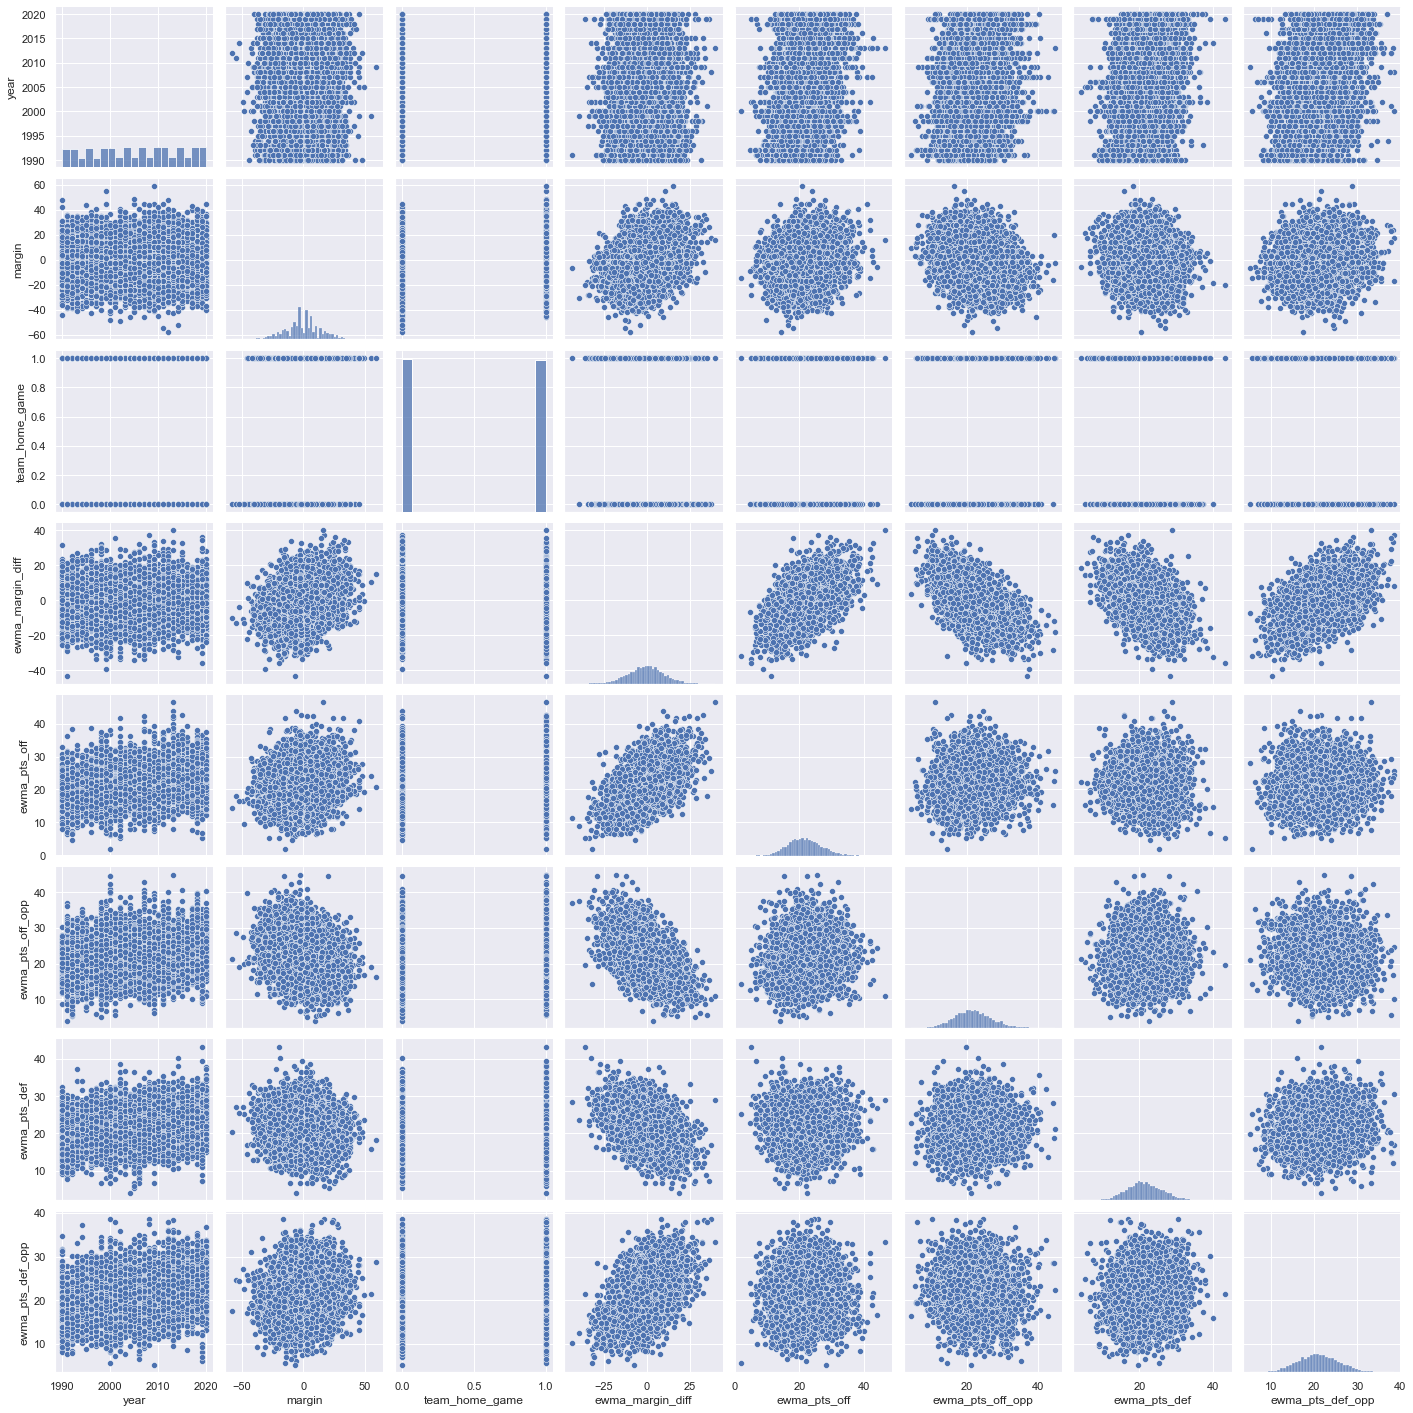

In [33]:
game_df['ewma_margin_diff'] = game_df['ewma_margin'] - game_df['ewma_margin_opp']

corr_check = game_df[['year', 'margin', 'team_home_game', 'ewma_margin_diff', 'ewma_pts_off',
                    'ewma_pts_off_opp', 'ewma_pts_def', 'ewma_pts_def_opp']]

sns.pairplot(corr_check)

In [34]:
model.predict(X.sample())

array([-5.23079134])

Okay, this 'margin_diff' column seems to have a linear relationship to our target.

In [35]:
X = game_df[['year', 'team_home_game', 'ewma_margin_diff', 'ewma_pts_off',
                    'ewma_pts_off_opp', 'ewma_pts_def', 'ewma_pts_def_opp']]

y = game_df['margin']

model = split_and_validate(X, y)

4978     28.0
6675    -13.0
3324     -2.0
10541    17.0
107     -27.0
Name: margin, dtype: float64

Validation R^2 score was: 0.1335012380502777
Feature coefficient results: 

year : 0.04
team_home_game : 5.72
ewma_margin_diff : 10.80
ewma_pts_off : -10.31
ewma_pts_off_opp : 10.19
ewma_pts_def : 10.32
ewma_pts_def_opp : -10.37


In [36]:
model.score(X, y)

0.15468431121572002

In [37]:
plot_cols = game_df.loc[:, [
 'margin',
 'team_home_game',
 'ewma_result_win',
 'ewma_result_tie',
 'ewma_pts_off',
 'ewma_pts_def',
 'ewma_margin',
 'ewma_first_down_off',
 'ewma_yards_off',
 'ewma_pass_yds_off',
 'margin',
 'ewma_rush_yds_off',
 'ewma_to_off',
 'ewma_to2_off',
 'ewma_yards_def',
 'ewma_pass_yds_def',
 'ewma_rush_yds_def',
 'ewma_to_def',
 'ewma_to2_def',
 'ewma_result_win_opp',
 'margin',
 'ewma_pts_off_opp',
 'ewma_pts_def_opp',
 'ewma_margin_opp',
 'ewma_first_down_off_opp',
 'ewma_yards_off_opp',
 'ewma_pass_yds_off_opp',
 'ewma_rush_yds_off_opp',
 'ewma_to_off_opp',
 'ewma_to2_off_opp',
 'margin',
 'ewma_yards_def_opp',
 'ewma_pass_yds_def_opp',
 'ewma_rush_yds_def_opp',
 'ewma_to_def_opp',
 'ewma_to2_def_opp']]

Now let's try adding wins ^ 2